# Environment Set Up

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#Visualization
import matplotlib.pyplot as plt

#Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import metrics

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-sbalg_5t because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
# Load dataset
data = np.load("/dataset/face-recognition/olivetti_faces.npy")
labels = np.load("/dataset/face-recognition/olivetti_faces_target.npy")

In [3]:
print("Total images:", len(data))
print("Total unique labels:",len(np.unique(labels)))
print("Image size: {}x{}".format(data.shape[1],data.shape[2]))
print("Example of pixel values: {}".format(data[0][0,:4]))

Total images: 400
Total unique labels: 40
Image size: 64x64
Example of pixel values: [0.30991736 0.3677686  0.41735536 0.44214877]


In [4]:
RANDOM_SEED = 7357

TOTAL_IMG = 400
IMG_SIZE_W = 64
IMG_SIZE_H = 64

TEST_SPLIT = 0.2

In [5]:
# Transform data from matrix to vectors
X = data.reshape((TOTAL_IMG, IMG_SIZE_W * IMG_SIZE_H))

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X, labels, test_size=0.2, stratify=labels, random_state=RANDOM_SEED)

Y_dataframe = pd.DataFrame()
Y_dataframe['face_id'] = Y_train

# PCA

It can be seen when performing a PCA variances analysis that more than 100 components don't improve the variance in a significative way. this is just by looking into the graph, optimal component number should be gathered by more in depth analysis.

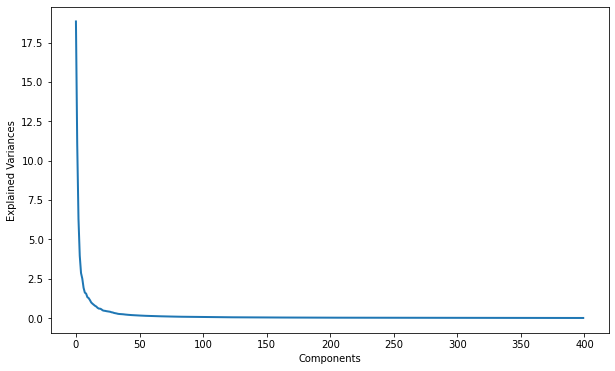

In [7]:
pca = PCA()
pca.fit(X)

plt.figure(1, figsize=(10,6))
plt.plot(pca.explained_variance_, linewidth=2)
plt.xlabel('Components')
plt.ylabel('Explained Variances')
plt.show()

Text(0.5, 1.0, 'Average Face')

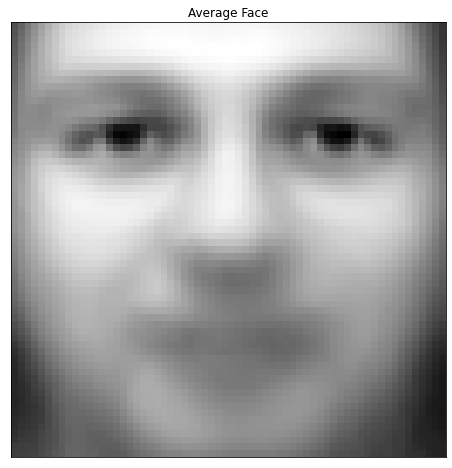

In [8]:
# Retrain with only 100 components
pca = PCA(n_components=100)
pca.fit(X_train)

# Show average face
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.imshow(pca.mean_.reshape((IMG_SIZE_W, IMG_SIZE_H)), cmap="gray")
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Average Face')

# Training

In [11]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [12]:
models=[]
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(("LR",LogisticRegression()))
models.append(("NB",GaussianNB()))
models.append(("KNN",KNeighborsClassifier(n_neighbors=5)))
models.append(("DT",DecisionTreeClassifier()))
models.append(("SVM",SVC()))

In [17]:
for modelName, model in models:
    model.fit(X_train_pca, Y_train)
    Y_pred = model.predict(X_test_pca)
    acc = metrics.accuracy_score(Y_test, Y_pred)
    print("{} accuracy: {:0.5f}\n".format(modelName, acc))

LDA accuracy: 1.00000

LR accuracy: 0.98750

NB accuracy: 0.91250

KNN accuracy: 0.85000

DT accuracy: 0.62500

SVM accuracy: 0.95000



# Validation

In [18]:
# PCA of all face (for cross validation)
pca = PCA(n_components=100)
pca.fit(X)
X_pca = pca.transform(X)

In [19]:
# LDA
cv = LeaveOneOut()
lda = LinearDiscriminantAnalysis()
cv_scores = cross_val_score(lda, X_pca, labels, cv=cv)
print("LDA val accuracy: {:.5f}".format(cv_scores.mean()))

LDA val accuracy: 0.98500


In [20]:
# LR
cv = LeaveOneOut()
lda = LogisticRegression()
cv_scores = cross_val_score(lda, X_pca, labels, cv=cv)
print("LR val accuracy: {:.5f}".format(cv_scores.mean()))

LR val accuracy: 0.98000


# Hyperparameter Tunning

LDA doesn't have hyperparameters to tune.

LR has 3 parameters but will only search for some of them (**not enough training time**):
- Solver: Default
- Penalty: l1, l2
- Regularization: 0.1, 1.0, 10.0

In [26]:
# May be would be best to use randomized grid search with limited attempts to search for all parameters and use continous values.

from sklearn.model_selection import GridSearchCV
parameters = {'penalty': ['l1', 'l2'], 'C': [0.1, 1.0, 10]}

In [27]:
RL = LogisticRegression()
cv = LeaveOneOut()
gridSearch = GridSearchCV(RL, parameters, cv=cv)
gridSearch.fit(X_train_pca, Y_train)

print("Best params:", gridSearch.best_params_)
print("Best score:", gridSearch.best_score_)

test_score = gridSearch.score(X_test_pca, Y_test)
print("Test score:", test_score)

Best params: {'C': 10, 'penalty': 'l2'}
Best score: 0.971875
Test score: 0.9875
